In [1]:
import warnings
warnings.filterwarnings('ignore')
import FateAxis.tool.main_function as fa
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import FateAxis.tool.extractor as ext
import cospar as cs
import scipy.stats as stats
import cospar as cs
from scipy.stats import rankdata
import FateAxis.tool.preprocessor as pp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 8137 × 31761
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.8', 'seurat_clusters', 'sample', 'replicate', 'predicted.id_cca_co', 'prediction.score.Fib_1_cca_co', 'prediction.score.Fib_0_cca_co', 'prediction.score.Fib_2_cca_co', 'prediction.score.Early_0_cca_co', 'prediction.score.Tran_0_cca_co', 'prediction.score.Tran_1_cca_co', 'prediction.score.Early_1_cca_co', 'prediction.score.Early_2_cca_co', 'prediction.score.iEP_1_cca_co', 'prediction.score.Tran_2_cca_co', 'prediction.score.iEP_2_cca_co', 'prediction.score.Dead.end_1_cca_co', 'prediction.score.Dead.end_0_cca_co', 'prediction.score.iEP_0_cca_co', 'prediction.score.Dead.end_2_cca_co', 'prediction.score.max_cca_co', 'RNA_snn_res.0.2', 'cellranger_ident', 'md_fate_rev1', 'md_fate_coarse_rev1', 'cell', 'barcodes', 'celltype', 'lineage', 'RNA_snn_res.0.05', 'UMAP_1', 'UMAP_2', 'state_info', '_scvi_batc

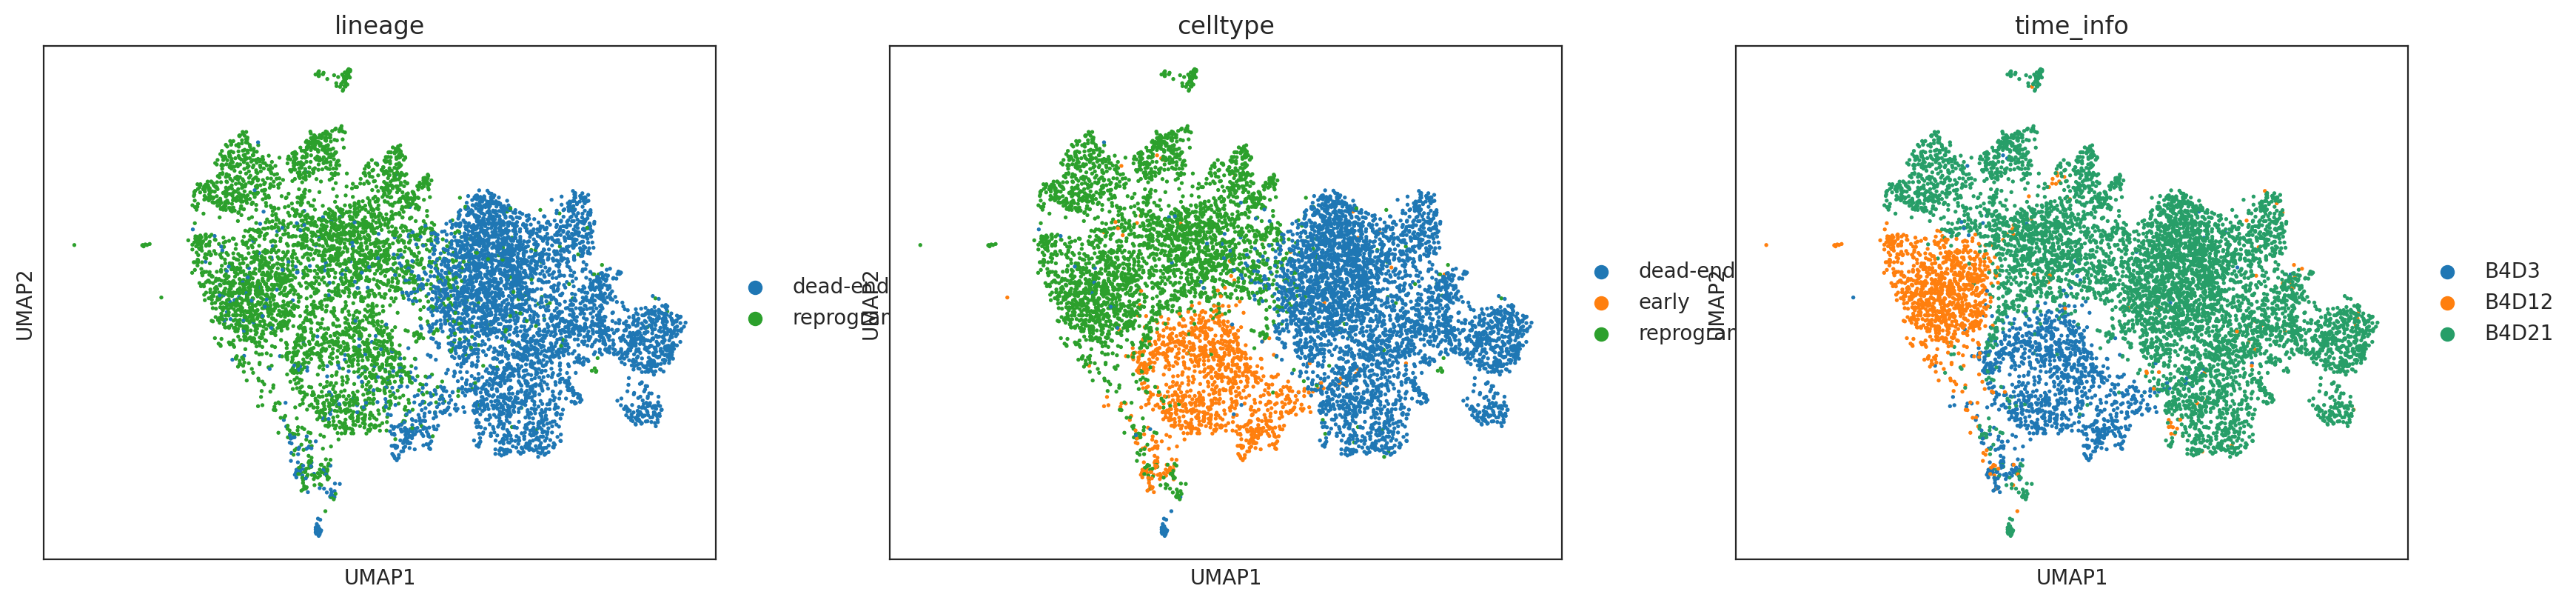

In [4]:
sc.pl.umap(adata,color=['lineage','celltype','time_info'])

In [5]:
adata.obs['time_info'] = 'late'
adata.obs.loc[adata.obs['celltype'] == 'early', 'time_info'] = 'early'

In [6]:
adata.obsm['X_emb'] = adata.obsm['X_umap']
adata.obs['state_info'] = adata.obs['celltype']
adata.obsm['X_pca'] = adata.obsm['X_scVI']
cs.pp.get_X_clone(adata,clone_data_barcode_id=adata.obs['barcodes'],clone_data_cell_id=adata.obs_names)
adata = cs.pp.initialize_adata_object(adata)

100%|██████████| 8137/8137 [00:00<00:00, 1310689.80it/s]

reorder clones
Time points with clonal info: ['early' 'late']


Step I: Generate pseudo clones where each cell has a unique barcode-----
Step II: Perform joint optimization-----
--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: early--------
Step 0: Pre-processing and sub-sampling cells-------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.01265859603881836
Smooth round: 2
--> Time elapsed: 0.08809947967529297
Smooth round: 3
--> Time elapsed: 0.6362414360046387
--> Orignal sparsity=0.188849354702405, Thresholding
--> Final sparsity=0.10850727318995494
similarity matrix truncated (Smooth round=3):  0.8394381999969482
Smooth round: 4
--> Time elapsed: 1.7074620723724365
--> Orignal sparsity=0.405496045514892, Thresholding
--> Final sparsity=0.19078364729459643
similarity matrix truncated (Smooth round=4):  0.902864933013916
Smooth round: 5
--> Time elapsed: 2.4617273807525635
--> Orignal sparsity=0.5585037231632214, Thresholding
--> F

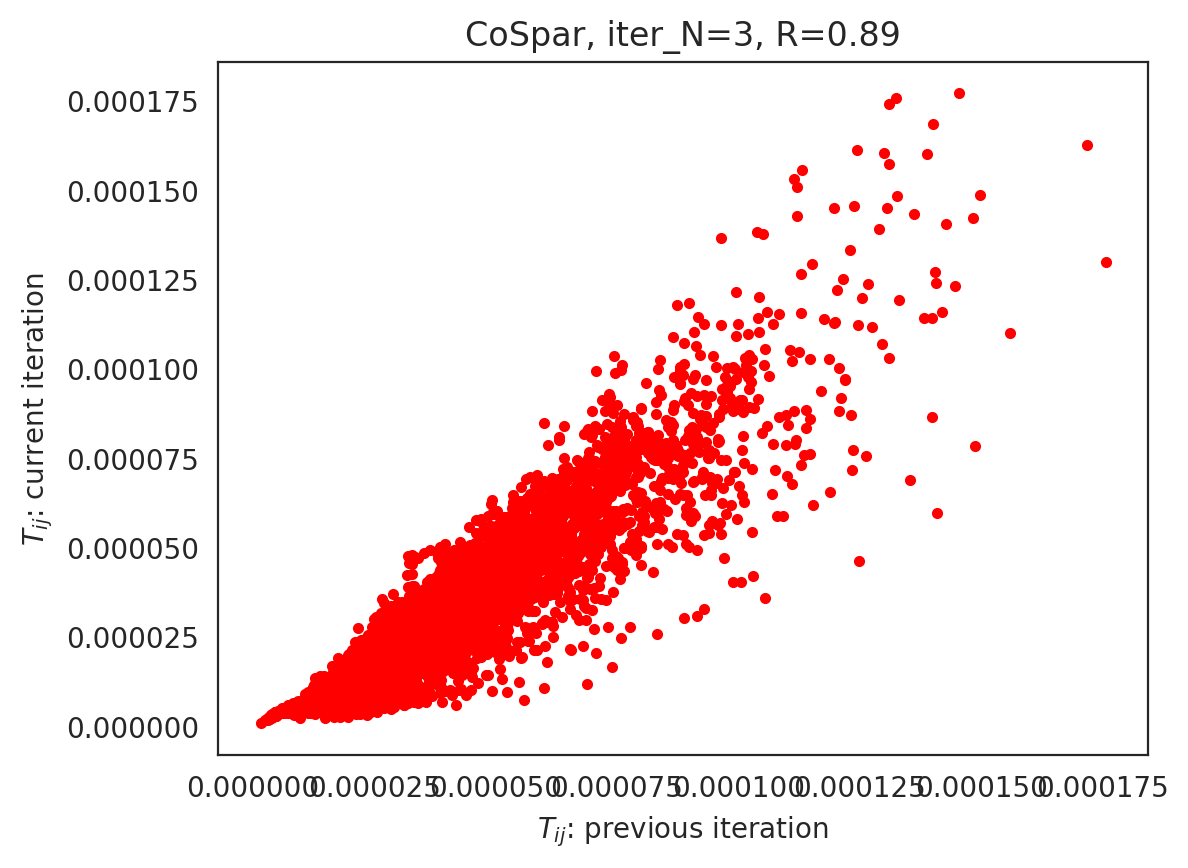

--> No need for Final Smooth (i.e., clonally-labeled states are the final state space for Tmap)
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
--> Clone id: 1000
--> Clone id: 2000
--> Clone id: 3000
--> Clone id: 4000
--> Clone id: 5000
--> Clone id: 6000


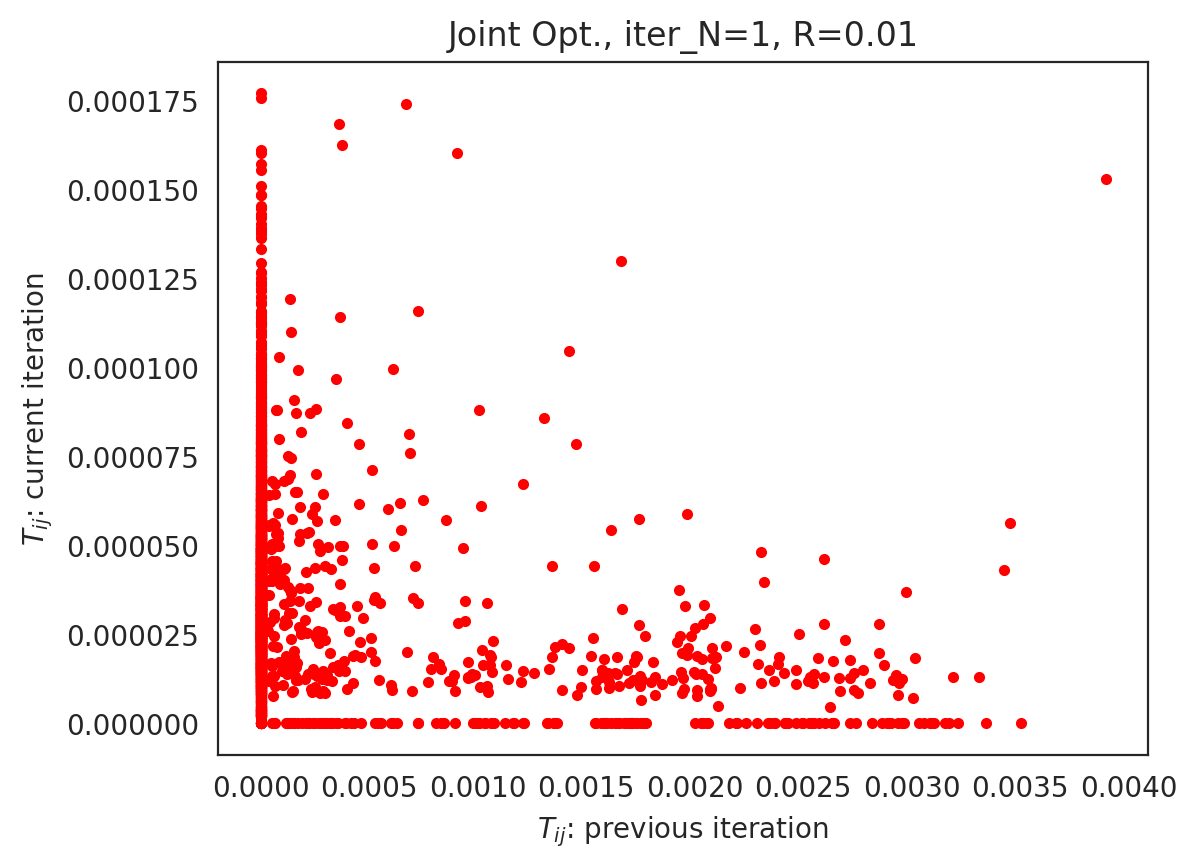

Finishing Joint Optimization, used time 26.527446269989014
-----------Total used time: 231.87409353256226 s ------------


In [7]:
adata_2 = cs.tmap.infer_Tmap_from_state_info_alone(
    adata,
    initial_time_points=["early"],
    later_time_point="late",
    initialize_method="OT",
    OT_cost="GED",
    smooth_array=[20, 15, 10],
    max_iter_N=[1, 3],
    sparsity_threshold=0.2,
    use_full_Smatrix=True,compute_new=True
)

In [8]:
cs.tl.progenitor(adata_2,selected_fates=['dead-end','reprogramming'])

Results saved at adata.obs['fate_map_transition_map_dead-end']
Results saved at adata.obs['fate_map_transition_map_reprogramming']
Results saved at adata.obs['fate_bias_transition_map_dead-end*reprogramming']
Results saved at adata.obs[f'progenitor_transition_map_dead-end'] and adata.obs[f'diff_trajectory_transition_map_dead-end']
Results saved at adata.obs[f'progenitor_transition_map_reprogramming'] and adata.obs[f'diff_trajectory_transition_map_reprogramming']


In [9]:
adata_2

AnnData object with n_obs × n_vars = 8137 × 31761
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.8', 'seurat_clusters', 'sample', 'replicate', 'predicted.id_cca_co', 'prediction.score.Fib_1_cca_co', 'prediction.score.Fib_0_cca_co', 'prediction.score.Fib_2_cca_co', 'prediction.score.Early_0_cca_co', 'prediction.score.Tran_0_cca_co', 'prediction.score.Tran_1_cca_co', 'prediction.score.Early_1_cca_co', 'prediction.score.Early_2_cca_co', 'prediction.score.iEP_1_cca_co', 'prediction.score.Tran_2_cca_co', 'prediction.score.iEP_2_cca_co', 'prediction.score.Dead.end_1_cca_co', 'prediction.score.Dead.end_0_cca_co', 'prediction.score.iEP_0_cca_co', 'prediction.score.Dead.end_2_cca_co', 'prediction.score.max_cca_co', 'RNA_snn_res.0.2', 'cellranger_ident', 'md_fate_rev1', 'md_fate_coarse_rev1', 'cell', 'barcodes', 'celltype', 'lineage', 'RNA_snn_res.0.05', 'UMAP_1', 'UMAP_2', 'state_info', '_scvi_batc

... storing 'time_info' as categorical


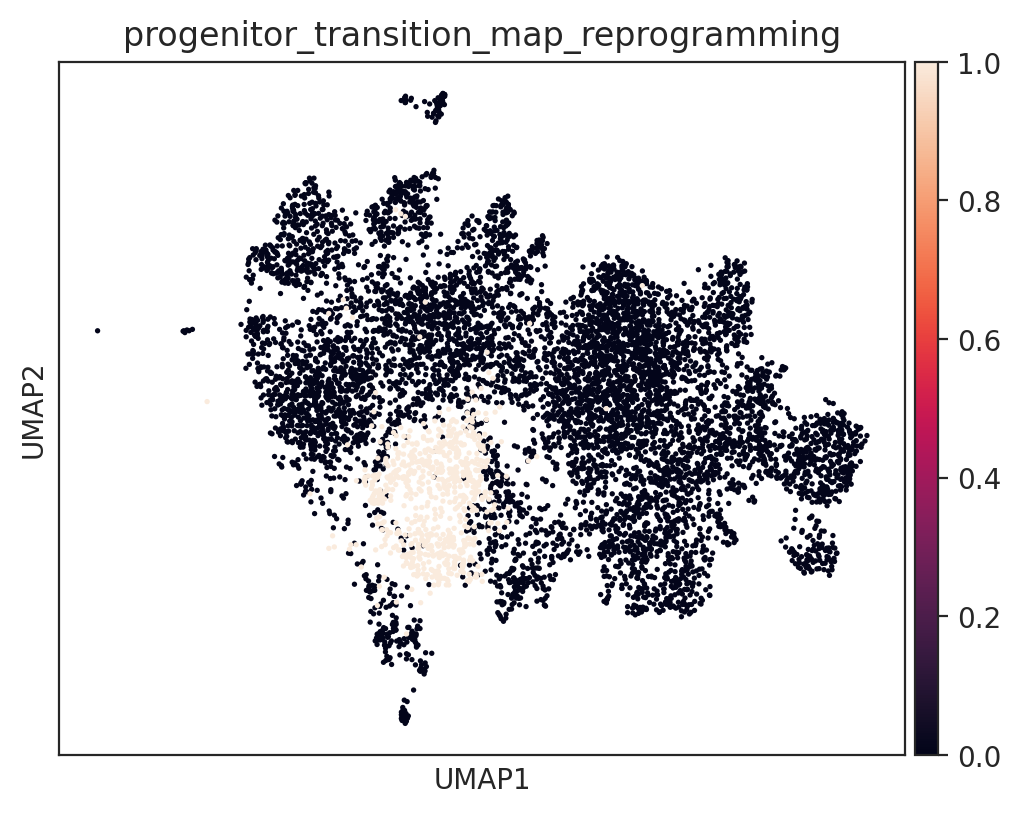

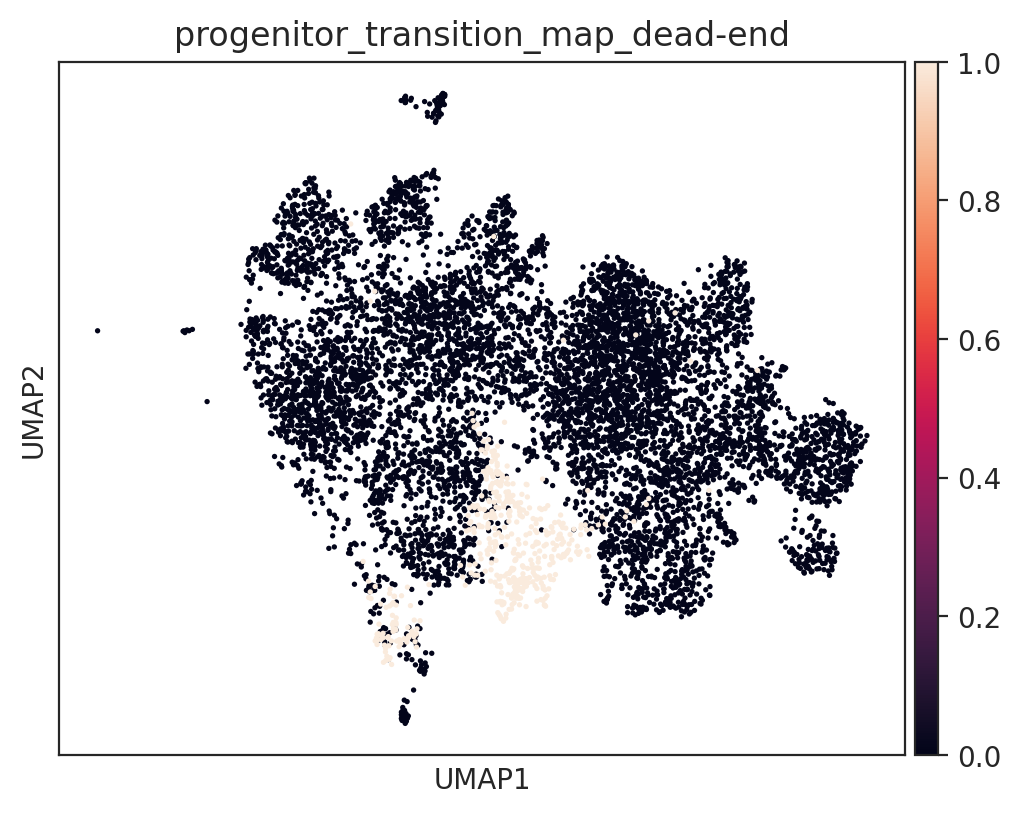

In [10]:
sc.pl.umap(adata_2,color='progenitor_transition_map_reprogramming')
sc.pl.umap(adata_2,color='progenitor_transition_map_dead-end')

In [11]:
adata.obs['pred'] = np.nan
condition = adata_2.obs['progenitor_transition_map_reprogramming'] == 1


# 将符合条件的行的 'pred' 列设置为 'reprogramming'
adata_2.obs.loc[condition, 'pred'] = 'reprogramming'
condition = adata_2.obs['progenitor_transition_map_dead-end'] == 1


# 将符合条件的行的 'pred' 列设置为 'reprogramming'
adata_2.obs.loc[condition, 'pred'] = 'dead-end'

In [12]:
adata_final = adata_2[adata_2.obs.celltype=='early']

... storing 'pred' as categorical


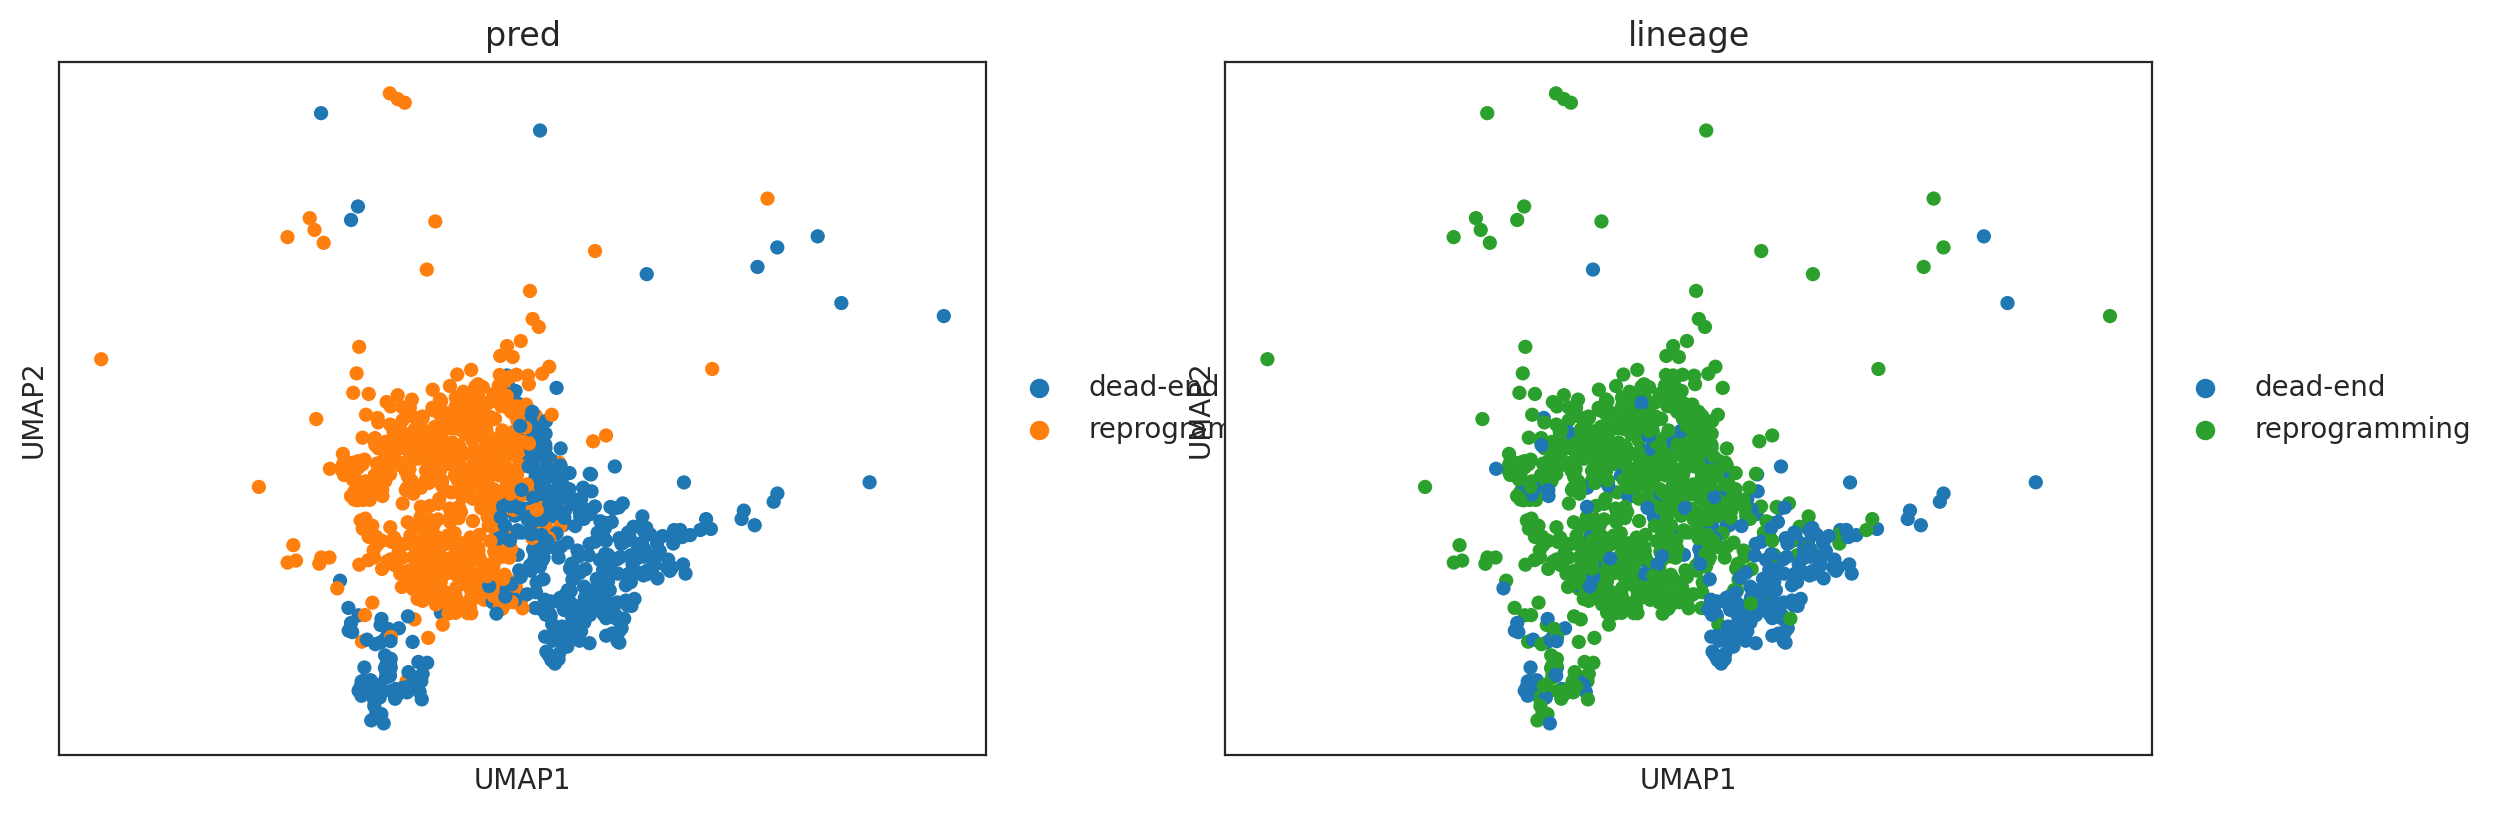

In [13]:
sc.pl.umap(adata_final,color=['pred','lineage'])

In [14]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
y_pred = adata_final.obs['pred']
y_true = adata_final.obs['lineage']

# 计算准确性

accuracy = accuracy_score(y_true, y_pred)

# 计算召回率

recall = recall_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 计算F1分数

f1 = f1_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 输出结果

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7436347673397717
Recall: 0.7684858714678671
F1 Score: 0.7093879976232917


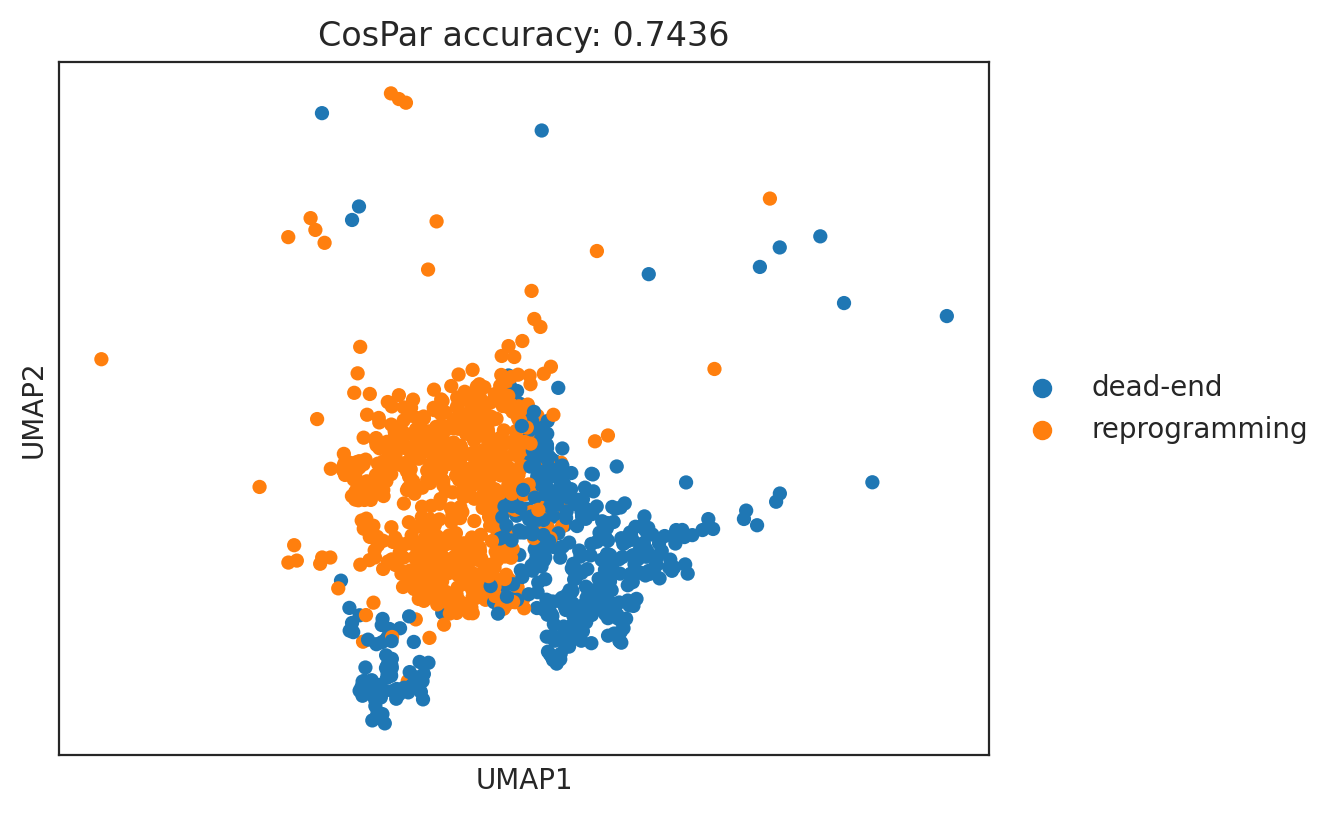

In [17]:
sc.pl.umap(adata_final,color=['pred'],title='CosPar accuracy: 0.7436')

In [16]:
adata.write('/data/jiangjunyao/AEGAS_analysis/pred_result/cospar_celltag_multi_rna_hvg.h5ad')
adata.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/cospar_celltag_multi_rna_obs.csv')

... storing 'time_info' as categorical
